# Convolutional AutoEncoder model for anomalies detection

## Strategy : ``Device``

In [1]:
# ---- utils libs ----
import numpy as np
import pandas as pd
import datetime
from typing import Optional

# --- Import functions from module.py ---
import sys
sys.path.insert(0,'..')
from module import plot_confusion_matrix, plot_activity_hist, load_dataset, load_aggregate_dataset, time_in_range, segmentDf, create_sequence, train_test_split_dataset, convertToSequenceParameters

# ---- Data Viz libs ---- 
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# ---- ML libs ----
from sklearn.preprocessing import StandardScaler

# ---- Deep Learning libs ----
from tensorflow import keras
from tensorflow.keras import layers

## Load Dataset

In [2]:
dataset_resampled_1H = load_dataset("house1_power_blk2_labels.zip","60min")
df_activity_resampled_1H = dataset_resampled_1H["activity"]
dataset_resampled_1H = dataset_resampled_1H["mains"]
df_mains_resampled_1H = pd.DataFrame(dataset_resampled_1H)
df_mains_resampled_1H

mains
datetime                   
2016-03-06 00:00:00   473.0
2016-03-06 01:00:00   736.0
2016-03-06 02:00:00   479.0
2016-03-06 03:00:00   467.0
2016-03-06 04:00:00   610.0
...                     ...
2016-05-07 18:00:00  1413.0
2016-05-07 19:00:00  1608.0
2016-05-07 20:00:00  1116.0
2016-05-07 21:00:00  2330.0
2016-05-07 22:00:00   594.0

[1511 rows x 1 columns]

## Visualize Load Curve

Résumé du dataset en prenant un point toute les heures

In [3]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_mains_resampled_1H.index, y=df_mains_resampled_1H['mains'], name='Load Curve'))
fig.update_layout(showlegend=True, title='house1_power_blk2_labels_60min')
fig.show()

Remarque ci-dessus : l'activité électrique diminue globalement pour le fichier "house1_power_blk2_labels", cela peut poser problème pour la séparation train/test

## Preprocessing

####  1/ Loads the dataset and resample timeseries
####  2/ Split a dataframe into train set and test set according to the split rate
####  3/ Standardize Data
####  4/ Construction of the dataset according to peak and off-peak hours or according to activity labels
####  5/ Creation of sequences of length T and according to the overlapping period

#### Return preprocessed ``3D-array`` ``[samples, SEQUENCE_LENGTH, features]`` (i.e sequences from the timeseries) , as required for **LSTM** network. We want our network to have memory of **10 days**, so we set ``SEQUENCE_LENGTH=10``.

#### Define Global Hyperparmètre

In [4]:
TIME_STEP = datetime.timedelta(minutes=1, seconds=30) # duration of a step in the resample dataset, originally 1 second
DURATION_TIME = datetime.timedelta(minutes=60) # duration of a sequence
OVERLAP_PERIOD_PERCENT = 0.8 # 0.5 <=> 50% overlapping
TIMEFRAMES = [(datetime.time(0,0,0), datetime.time(3,0,0))] # timeframes we consider as unactive
STRATEGY = "off_peak_time" # device, off_peak_time, label 

SEQUENCE_LENGTH, OVERLAP_PERIOD = convertToSequenceParameters(TIME_STEP, DURATION_TIME, OVERLAP_PERIOD_PERCENT)

print("\t\tValeur choisie \t Equivalent sequence\nTimestep : \t {}\nDuration :\t {} \t -->  {} \nOverlap :\t {} \t\t -->  {}".format(TIME_STEP, DURATION_TIME, SEQUENCE_LENGTH, OVERLAP_PERIOD_PERCENT, OVERLAP_PERIOD))

		Valeur choisie 	 Equivalent sequence
Timestep : 	 0:01:30
Duration :	 1:00:00 	 -->  40 
Overlap :	 0.8 		 -->  32


In [5]:
df_mains_resampled_1H.loc[:, ['mains']]

mains
datetime                   
2016-03-06 00:00:00   473.0
2016-03-06 01:00:00   736.0
2016-03-06 02:00:00   479.0
2016-03-06 03:00:00   467.0
2016-03-06 04:00:00   610.0
...                     ...
2016-05-07 18:00:00  1413.0
2016-05-07 19:00:00  1608.0
2016-05-07 20:00:00  1116.0
2016-05-07 21:00:00  2330.0
2016-05-07 22:00:00   594.0

[1511 rows x 1 columns]

In [6]:
def preprocessing(timeframes: list
                  ,sequence_length: int, overlap_period: int
                  ,resample_period :Optional[str]=None
                  ,use_labels :Optional[bool]=False
                  ,strategy :Optional[str] = "off_peak_time" 
                  ,split_rate :Optional[float]=0.2) -> np.array:
    """
    1/ Loads the dataset and resample timeseries
    2/ Split a dataframe into train set and test set according to the split rate
    3/ Standardize Data
    4/ Construction of the dataset according to peak and off-peak hours 
    or according to activity labels
    5/ Creation of sequences of length T and according to the overlapping period
    
    Args:
        - resample_period: (optional) the reasmple period, if None the default period of 1 second will be used
        - timeframes: list of tuples indicating the periods of the day ex: timeframes = [(datetime.time(10,0,0), datetime.time(6,0,0)), (datetime.time(12,0,0), datetime.time(13,0,0))
        - use_labels: (False by default) use the activities labels
        - sequence_length: length of the sequence
        - overlap_period: overlap the sequences of timeseries
        - device_approach: the aggregated load curve of the devices which, when in operation, do not allow us to predict an activity 
        - split_rate: Rate of the test set size
        - device_strategy: use inactive devices base load curve
    Returns: 
        - list of prepocessed 3D-array [samples, sequence_length, features] (i.e sequences from the timeseries) 
    """
        
    # load dataset with labels and resampled timeseries
    df_resampled = load_dataset("house1_power_blk2_labels.zip", resample_period)
    
    # split dataframe into train set and test set
    train_df, test_df = train_test_split_dataset(df_resampled)
    
    # Standardize Data
    scaler = StandardScaler()
    scaler_train = scaler.fit(train_df.loc[:, ['mains']])
    
    train_df.loc[:, 'mains'] = scaler_train.transform(train_df.loc[:, ['mains']])
    test_df.loc[:, 'mains'] = scaler_train.transform(test_df.loc[:, ['mains']])
        
#     # ---- TEST SEQUENCES ----
    X_sequences_test, y_sequences_test = create_sequence(test_df, sequence_length, overlap_period)
#     print('Duplicates in test_df : ', test_df.duplicated().any())
#     if STRATEGY == "device":
#         # load dataset with labels and resampled timeseries
#         df_resampled_with_labels = load_dataset("house1_power_blk2_labels.zip", resample_period)
#         # load dataset with inactive devices
#         df_resampled_devices_inactive = load_aggregate_dataset("house1_power_blk2.zip", "inactive_house2", resample_period)
#         activity = df_resampled_with_labels["activity"]
#         df_resampled_device = df_resampled_devices_inactive.join(activity)
#         df_resampled_device['mains'] = scaler_train.transform(df_resampled_device[['mains']])
        
#         # --- TRAIN SEQUENCES ----
#         X_sequence_train_device, y_sequence_train_device = create_sequence(df_resampled_device, sequence_length, overlap_period)
        
#         return df_resampled_device, test_df, X_sequence_train_device, y_sequence_train_device, X_sequences_test, y_sequences_test
    
    
#     if STRATEGY == "label":
#         # load dataset with labels and resampled timeseries
#         df_resampled_with_labels = load_dataset("house1_power_blk2_labels.zip", resample_period)
#         df_resampled_with_labels = df_resampled_with_labels[df_resampled_with_labels.activity == 0]
#         df_resampled_with_labels['mains'] = scaler_train.transform(df_resampled_with_labels[['mains']])
        
#         # --- TRAIN SEQUENCES ----
#         X_sequence_train_label, y_sequence_train_label = create_sequence(df_resampled_with_labels, sequence_length, overlap_period)
        
#         return df_resampled_with_labels, test_df, X_sequence_train_label, y_sequence_train_label, X_sequences_test, y_sequences_test
    
    
    if STRATEGY == "off_peak_time":
        # --- TRAIN SEQUENCES ----
        # Construction of the dataset according to peak and off-peak hours 
        list_df_train = segmentDf(train_df, timeframes = timeframes)

        # init 3D-array [samples, sequence_length, features]
        first_df_train = list_df_train[0]
        list_X_sequence_train, list_y_sequence_train = create_sequence(first_df_train, sequence_length, overlap_period)
        list_df_train.pop(0) # delete the first element of the list of train dataframes

        # Creation of sequences of length T and according to the overlapping period
        for df_train_ in list_df_train:
            X_sequences_train, y_sequences_train = create_sequence(df_train_, sequence_length, overlap_period)
            list_X_sequence_train = np.append(list_X_sequence_train, X_sequences_train, axis = 0)
            list_y_sequence_train = np.append(list_y_sequence_train, y_sequences_train, axis = 0)
        
        return list_df_train, train_df, test_df, list_X_sequence_train, list_y_sequence_train, X_sequences_test, y_sequences_test

In [7]:
# if STRATEGY == "device":
#     resampled_device_train_df, test_df, X_train, y_train, X_test, y_test = preprocessing( 
#                               timeframes = TIMEFRAMES
#                               ,sequence_length = SEQUENCE_LENGTH
#                               ,overlap_period = OVERLAP_PERIOD
#                               ,resample_period = TIME_STEP
#                               ,strategy = STRATEGY)
    
# if STRATEGY == "label":
#     resampled_label_train_df, test_df, X_train, y_train, X_test, y_test = preprocessing( 
#                               timeframes = TIMEFRAMES
#                               ,sequence_length = SEQUENCE_LENGTH
#                               ,overlap_period = OVERLAP_PERIOD
#                               ,resample_period = TIME_STEP
#                               ,strategy = STRATEGY)
    
if STRATEGY == "off_peak_time":
    print("Strategy chosen : off_peak_time")
    list_df_train, train_df, test_df, X_train, y_train, X_test, y_test = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY)

Strategy chosen : off_peak_time


C:\Users\leroy\AppData\Local\Temp\ipykernel_19108\4174662572.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\leroy\AppData\Local\Temp\ipykernel_19108\4174662572.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\leroy\OneDrive\Bureau\K\2_MS_TelecomParis\Cours\Projet_Fil_Rouge\Activity_Detection_From_Electrical_Consumption_Load_Curves\Convolutional Auto Encoder\..\module.py:453: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [8]:
# if STRATEGY == "device":
#     print("---- train DataFrame Device shape ----")
#     print(resampled_device_train_df.shape)
    
    
# if STRATEGY == "label":
#     print("---- train DataFrame Label shape ----")
#     print(resampled_label_train_df.shape)
    
    
if STRATEGY == "off_peak_time":
    print("---- train DataFrame Off-Peak-Time shape ----")
    print(train_df.shape)

---- train DataFrame Off-Peak-Time shape ----
(48352, 3)


In [9]:
print("---- test DataFrame shape ----")
test_df.shape

---- test DataFrame shape ----


(12088, 3)

### Visualize ``train_df``

In [10]:
# if STRATEGY == "device":
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=resampled_device_train_df.index, y=resampled_device_train_df['mains'], name='Load Curve'))
#     fig.update_layout(showlegend=True, title='resampled_device_train_df')
#     fig.show()
    
# if STRATEGY == "label":
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=resampled_label_train_df.index, y=resampled_label_train_df['mains'], name='Load Curve'))
#     fig.update_layout(showlegend=True, title='resampled_label_train_df')
#     fig.show()
    
if STRATEGY == "off_peak_time":
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_df.index, y=train_df['mains'], name='Load Curve'))
    fig.update_layout(showlegend=True, title='train_df')
    fig.show()

### Visualize ``test_df``

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['mains'], name='Load Curve'))
fig.update_layout(showlegend=True, title='test_df')
fig.show()

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['mains'], name='Train'))
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['mains'], name='Test'))
fig.update_layout(showlegend=True, title='train test split of Dataframe',xaxis_title="Date",
    yaxis_title="mains (power, normalized)",
    legend_title="Dataframe")
fig.show()
print("train_df[mains].mean()", train_df["mains"].mean())
print("test_df[mains].mean()", test_df["mains"].mean())

train_df[mains].mean() -1.1121425862742852e-15
test_df[mains].mean() -0.3282213667296779


### Visualize ``list_df_train``

In [13]:
if STRATEGY == "off_peak_time":
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list_df_train[6].index, y=list_df_train[6]['mains'], name='Load Curve'))
    fig.update_layout(showlegend=True, title='list_df_train'+str(2))
    fig.show()
    
print("TIME_STEP value : ", TIME_STEP)

TIME_STEP value :  0:01:30


### Verify the shape of the sequence

In [14]:
print("---- X_train sequence shape ----")
print(X_train.shape)

print("\n---- y_train sequence shape ----")
print(y_train.shape)

print("\n\n---- X_test sequence shape ----")
print(X_test.shape)

print("\n---- y_test sequence shape ----")
print(y_test.shape)

---- X_train sequence shape ----
(561, 40, 1)

---- y_train sequence shape ----
(561, 40, 3)


---- X_test sequence shape ----
(1506, 40, 1)

---- y_test sequence shape ----
(1506, 40, 3)


### Visualize the sequence

In [15]:
print("---- X_train sequence ----")
X_train

---- X_train sequence ----


array([[[-0.71576861],
        [-0.70545704],
        [-0.71473745],
        ...,
        [-0.82610242],
        [-0.73329828],
        [-0.41157727]],

       [[-0.72298671],
        [-0.55800157],
        [-0.57759356],
        ...,
        [-0.84363209],
        [-0.8384763 ],
        [-0.8240401 ]],

       [[-0.70442588],
        [-0.70751935],
        [-0.70751935],
        ...,
        [-0.44560545],
        [-0.31877313],
        [-0.45591702]],

       ...,

       [[-0.73432944],
        [-0.55387695],
        [-0.56625083],
        ...,
        [-0.74257869],
        [-0.70751935],
        [-0.72298671]],

       [[-0.57140662],
        [-0.61780868],
        [-0.74464101],
        ...,
        [-0.66111728],
        [-0.61883984],
        [-0.75495258]],

       [[-0.72504902],
        [-0.54665885],
        [-0.54975232],
        ...,
        [-0.59512323],
        [-0.55593926],
        [-0.42910694]]])

In [16]:
print("---- y_train sequence ----")
y_train

---- y_train sequence ----


array([[[Timestamp('2016-03-06 00:00:00'), 0, 0],
        [Timestamp('2016-03-06 00:01:30'), 0, 1],
        [Timestamp('2016-03-06 00:03:00'), 0, 2],
        ...,
        [Timestamp('2016-03-06 00:55:30'), 0, 37],
        [Timestamp('2016-03-06 00:57:00'), 0, 38],
        [Timestamp('2016-03-06 00:58:30'), 0, 39]],

       [[Timestamp('2016-03-06 00:12:00'), 0, 8],
        [Timestamp('2016-03-06 00:13:30'), 0, 9],
        [Timestamp('2016-03-06 00:15:00'), 0, 10],
        ...,
        [Timestamp('2016-03-06 01:07:30'), 0, 45],
        [Timestamp('2016-03-06 01:09:00'), 0, 46],
        [Timestamp('2016-03-06 01:10:30'), 0, 47]],

       [[Timestamp('2016-03-06 00:24:00'), 0, 16],
        [Timestamp('2016-03-06 00:25:30'), 0, 17],
        [Timestamp('2016-03-06 00:27:00'), 0, 18],
        ...,
        [Timestamp('2016-03-06 01:19:30'), 0, 53],
        [Timestamp('2016-03-06 01:21:00'), 0, 54],
        [Timestamp('2016-03-06 01:22:30'), 0, 55]],

       ...,

       [[Timestamp('2016-04-2

In [17]:
print("---- X_test sequence ----")
X_test

---- X_test sequence ----


array([[[-0.44869892],
        [-0.66111728],
        [-0.6631796 ],
        ...,
        [-0.54459653],
        [-0.44663661],
        [-0.3074304 ]],

       [[-0.58687397],
        [-0.42704462],
        [-0.58481166],
        ...,
        [-0.5765624 ],
        [-0.50541256],
        [-0.51572413]],

       [[-0.32083545],
        [-0.45694818],
        [-0.34867669],
        ...,
        [-0.44869892],
        [-0.3435209 ],
        [-0.44663661]],

       ...,

       [[-0.12388444],
        [-0.14038296],
        [-0.03520493],
        ...,
        [-0.57759356],
        [-0.68277158],
        [-0.68689621]],

       [[-0.55903273],
        [-0.57965587],
        [-0.63224488],
        ...,
        [-0.42704462],
        [-0.56109505],
        [-0.57450009]],

       [[-0.45282355],
        [-0.45488587],
        [-0.57965587],
        ...,
        [-0.70855051],
        [-0.70442588],
        [-0.5549081 ]]])

In [18]:
print("---- y_test sequence ----")
y_test

---- y_test sequence ----


array([[[Timestamp('2016-04-25 08:48:00'), 0, 0],
        [Timestamp('2016-04-25 08:49:30'), 0, 1],
        [Timestamp('2016-04-25 08:51:00'), 0, 2],
        ...,
        [Timestamp('2016-04-25 09:43:30'), 0, 37],
        [Timestamp('2016-04-25 09:45:00'), 0, 38],
        [Timestamp('2016-04-25 09:46:30'), 0, 39]],

       [[Timestamp('2016-04-25 09:00:00'), 0, 8],
        [Timestamp('2016-04-25 09:01:30'), 0, 9],
        [Timestamp('2016-04-25 09:03:00'), 0, 10],
        ...,
        [Timestamp('2016-04-25 09:55:30'), 0, 45],
        [Timestamp('2016-04-25 09:57:00'), 0, 46],
        [Timestamp('2016-04-25 09:58:30'), 0, 47]],

       [[Timestamp('2016-04-25 09:12:00'), 0, 16],
        [Timestamp('2016-04-25 09:13:30'), 0, 17],
        [Timestamp('2016-04-25 09:15:00'), 0, 18],
        ...,
        [Timestamp('2016-04-25 10:07:30'), 0, 53],
        [Timestamp('2016-04-25 10:09:00'), 0, 54],
        [Timestamp('2016-04-25 10:10:30'), 0, 55]],

       ...,

       [[Timestamp('2016-05-0

## Build a model

We will build a convolutional reconstruction autoencoder model. The model will take input of shape (``batch_size``, ``sequence_length``, ``num_features``) and return output of the same shape. In this case, ``sequence_length`` is **10** and ``num_features`` is **1**.

In [19]:
X_train.shape # 3d Array (samples, SEQUENCE_LENGTH, num_features)

(561, 40, 1)

In [20]:
X_train.shape[1]

40

In [21]:
X_train.shape[2]

1

In [22]:
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=4, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 32)            256       
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 20, 16)           1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 20, 16)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 40, 32)           3616      
 ranspose)                                              

### Train the model

Please note that we are using ``X_train`` as both the input and the target since this is a reconstruction model.

In [23]:
history = model.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
4/4 [==============================] - 1s 116ms/step - loss: 0.3623 - val_loss: 0.2997
Epoch 2/50
4/4 [==============================] - 0s 10ms/step - loss: 0.2818 - val_loss: 0.1888
Epoch 3/50
4/4 [==============================] - 0s 10ms/step - loss: 0.1550 - val_loss: 0.0497
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0746 - val_loss: 0.0533
Epoch 5/50
4/4 [==============================] - 0s 11ms/step - loss: 0.0933 - val_loss: 0.0282
Epoch 6/50
4/4 [==============================] - 0s 11ms/step - loss: 0.0607 - val_loss: 0.0351
Epoch 7/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0655 - val_loss: 0.0416
Epoch 8/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0640 - val_loss: 0.0295
Epoch 9/50
4/4 [==============================] - 0s 11ms/step - loss: 0.0550 - val_loss: 0.0214
Epoch 10/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0549 - val_loss: 0.0209
Epoch 11/50
4/4 [===========

### Evaluation of the model

Let's plot training and validation loss to see how the training went.

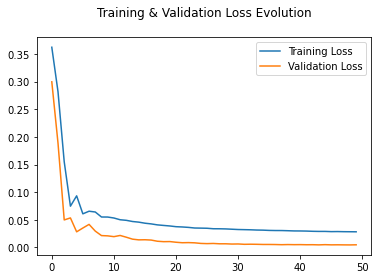

In [24]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss Evolution\n")
plt.show()

### Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct the input data.

**1/** Find ``MAE`` loss on training samples.

**2/** Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the ``threshold`` for anomaly detection.

**3/** If the reconstruction loss for a sample is greater than this ``threshold`` value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an **anomaly.**

In [25]:
X_train_pred = model.predict(X_train)
X_train_pred.shape

(561, 40, 1)

In [26]:
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
train_mae_loss.shape

(561, 1)

c:\Users\leroy\anaconda3\envs\baalbek2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



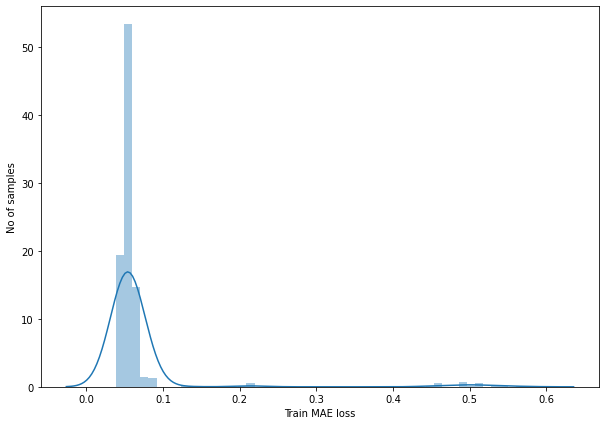

Reconstruction error threshold:  0.5709820666760328


In [27]:
# Get train MAE loss.
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.figure(figsize = (10, 7))
sns.distplot(train_mae_loss, bins=50, kde = True)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample. This is the **40** timesteps from day 1 of our training dataset.

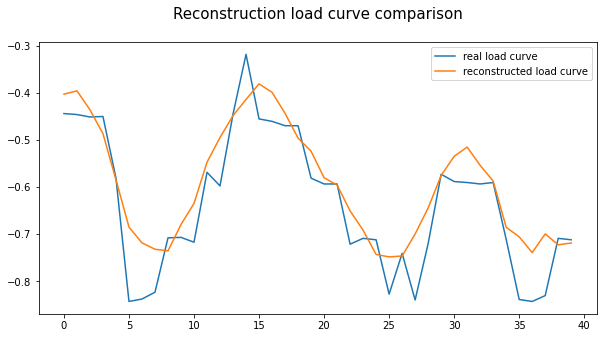

In [28]:
# Checking how the first sequence is learnt
plt.figure(figsize = (10, 5))
plt.plot(X_train[5], label="real load curve")
plt.plot(X_train_pred[5], label="reconstructed load curve")
plt.title("Reconstruction load curve comparison\n", fontsize=15)
plt.legend()
plt.show()

### Prepare test data

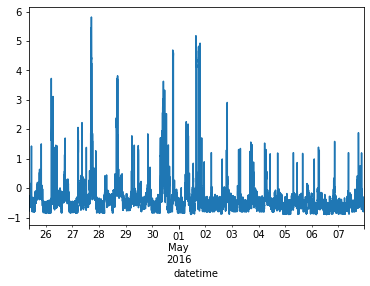

In [29]:
df_test_value = test_df["mains"]
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

In [30]:
print("Test input shape: ", X_test.shape)

Test input shape:  (1506, 40, 1)


c:\Users\leroy\anaconda3\envs\baalbek2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



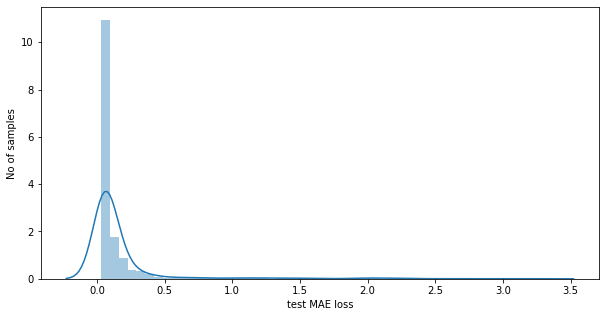

Number of anomaly samples: 
85


Indices of anomaly samples: 
(array([ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 235, 236,
       237, 238, 239, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
       390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 599, 600,
       601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 645,
       646, 647, 648, 649, 650, 651, 707, 708, 709, 710, 711, 712, 713,
       714, 715, 716, 750, 751, 752, 753, 754, 755, 756, 761, 762, 763,
       764, 765, 766, 767, 768, 769, 770], dtype=int64),)


In [31]:
# Get test MAE loss.
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.figure(figsize = (10, 5))
sns.distplot(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ")
print(np.sum(anomalies))

print("\n\nIndices of anomaly samples: ")
print(np.where(anomalies))

In [32]:
X_test[0]

array([[-0.44869892],
       [-0.66111728],
       [-0.6631796 ],
       [-0.63636951],
       [-0.78382498],
       [-0.75082795],
       [-0.54975232],
       [-0.57965587],
       [-0.58687397],
       [-0.42704462],
       [-0.58481166],
       [-0.59924786],
       [-0.44869892],
       [-0.34455206],
       [-0.36001941],
       [-0.26102833],
       [-0.32083545],
       [-0.45694818],
       [-0.34867669],
       [-0.32805354],
       [-0.35486363],
       [-0.36826867],
       [-0.34867669],
       [-0.3723933 ],
       [-0.31052387],
       [-0.51778645],
       [-0.5332538 ],
       [-0.51469298],
       [-0.42807578],
       [-0.38167371],
       [-0.53222265],
       [-0.49613215],
       [-0.56418852],
       [-0.56831315],
       [-0.50747488],
       [-0.65905497],
       [-0.50231909],
       [-0.54459653],
       [-0.44663661],
       [-0.3074304 ]])

In [33]:
X_test[98]

array([[-0.75701489],
       [-0.84775671],
       [-0.85085019],
       [-0.84775671],
       [-0.75598373],
       [-0.60852827],
       [-0.61883984],
       [-0.63533836],
       [-0.48891405],
       [-0.34867669],
       [-0.49716331],
       [-0.59615439],
       [-0.58584282],
       [-0.59202976],
       [-0.60749711],
       [-0.6126529 ],
       [-0.60749711],
       [-0.61162174],
       [-0.61471521],
       [-0.15172568],
       [-0.10532362],
       [ 1.54659003],
       [ 3.54497245],
       [ 3.72851841],
       [ 1.74354103],
       [ 1.80128583],
       [ 1.62702028],
       [ 1.64248764],
       [ 1.67136004],
       [ 1.69610781],
       [ 1.64970574],
       [ 1.61773987],
       [ 1.66001731],
       [ 1.76931996],
       [ 1.78891194],
       [ 1.75797723],
       [ 1.77447574],
       [ 1.78066269],
       [ 1.89718344],
       [ 2.1023837 ]])

In [34]:
# get index of each sequence considered as an anomaly
sequences_anomalies_idx = list()
for i in range(len(anomalies)):
    if anomalies[i] == True:
        sequences_anomalies_idx.append(i)

# get index of each data point from X_test considered as an anomaly 
data_anomalies_idx = list()
for elm in sequences_anomalies_idx:
    for i in range(SEQUENCE_LENGTH):
        data_idx = y_test[elm][i][2] 
        data_anomalies_idx.append(data_idx)

print("Number of data points considered as anomalies (= activity) : ", len(data_anomalies_idx))

Number of data points considered as anomalies (= activity) :  3400


### Plot all the sequences > ``threshold`` as an anomalie  

In [35]:
df_subset = df_test_value.iloc[data_anomalies_idx]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test_value.index, y=df_test_value.values, name='Normal'))
fig.add_trace(go.Scatter(x=df_subset.index, y=df_subset.values, mode='markers', name='Anomaly = Activity (Predicted)'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

### Plot data point > ``threshold`` of each sequences considered as an anomaly 

Ici : pour chaque séquence considérée comme une anomalie, on propose de visualiser les points pour lesquels l'écart est le plus important entre le point original et le point reconstruit.

In [36]:
# a = vecteur des timestamps en anomalie
a = y_test[:, :, 0][np.abs((X_test_pred - X_test)>threshold).squeeze()]
a = np.unique(a, return_counts=True)

df_subset = df_test_value.iloc[data_anomalies_idx]
df_subset = df_subset[df_subset.index.isin(a[0])] # a[0] car a[1] contient les comptes
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test_value.index, y=df_test_value.values, name='Normal'))
fig.add_trace(go.Scatter(x=df_subset.index, y=df_subset.values, mode='markers', name='Anomaly = Activity (Predicted)'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

# A faire
- Prédiction de l'activité, plusieurs options : (nécessite peut-être de créer une nouvelle variable globale)
    - A partir de la séquence complète
    - A partir du compte du nombre de fois où un point est mal reconstruit (erreur calculée sur les points)
    - A partir du compte du nombre de séquences classées comme anomalies dans lequel un point apparaît
- Risque de surestimation de l'activité, à corriger le cas échéant (cf premiers résultats même si un peu faussés)
- Affiner le threshold
    - Quantile plutôt que hard maximum sur le train_set : permet d'avoir un peu plus de liberté dans le train (risque de mal se généraliser sinon)
- Stratégie de train/test split : sur la maison 2 le test n'est pas comparable au train car moins d'énergie
    - Sampler des périodes aléatoires
- Variables globales, hyperparamètres et modèle:
    - peut-être pas assez de données train -> reduire timestep, augmenter overlap/timeframe
    - Optimiser les HP/VG
    - S'assurer que le modèle est bien dimensionné (pour l'instant assez rapide à entraîner, ne reconstruit peut-être pas aussi bien que souhaité)
- Métrique d'évaluation : problème à 2 time series 0/1 comparaison
    - Basée sur la présence d'une période ou pas plutôt que sur un overlap
- Plots :
    - Affichage des points en fonction du nombre de fois où ils sont en anomalie sur les séquences
    - anomalie trouvées sur le test vs nuit
    - anomalie trouvées sur le test vs activité
    - erreur de reconstruction
    - Exemples de courbes bien reconstruites (pas d'anomalie) et exemples de courbes mal reconstruites (séquences en anomalie)
    
## Commentaire
- Pas sûr que le modèle performe
    - ici sans optimisation des HP, les performances ne sont pas exceptionnelles, quelle est la marge de progression du modèle ? Est-il suffisamment prometteur pour le pousser ?

# Old

Pas correct en l'état, à mettre à jour

### Plot data point > ``threshold`` of each sequences considered as an anomaly 

In [37]:
df_subset_pred = pd.DataFrame(df_subset)
df_subset_pred["activity_pred"] = 1
df_subset_pred

Empty DataFrame
Columns: [mains, activity_pred]
Index: []

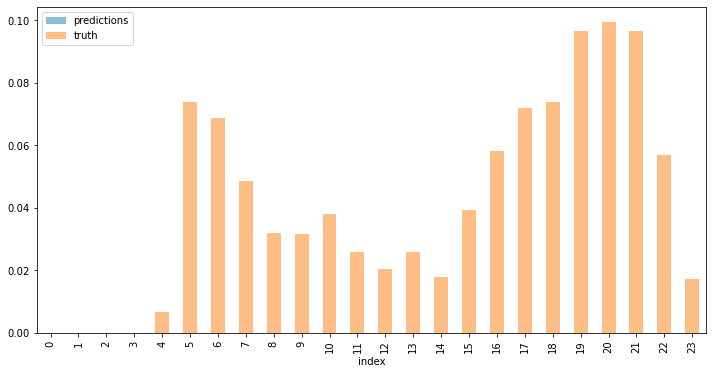

In [38]:
fig, ax = plt.subplots()

plot_activity_hist(df_subset_pred['activity_pred'], figsize=(12, 6), alpha=0.5, label='predictions', ax=ax)
plot_activity_hist(test_df["activity"], figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)

In [39]:
test_df

mains  activity       hour
datetime                                          
2016-04-25 08:48:00 -0.448699         0   8.800000
2016-04-25 08:49:30 -0.661117         0   8.816667
2016-04-25 08:51:00 -0.663180         0   8.850000
2016-04-25 08:52:30 -0.636370         0   8.866667
2016-04-25 08:54:00 -0.783825         0   8.900000
...                       ...       ...        ...
2016-05-07 22:52:30 -0.697208         0  22.866667
2016-05-07 22:54:00 -0.655961         0  22.900000
2016-05-07 22:55:30 -0.679678         0  22.916667
2016-05-07 22:57:00 -0.572438         0  22.950000
2016-05-07 22:58:30 -0.575531         0  22.966667

[12088 rows x 3 columns]

In [40]:
test_df

mains  activity       hour
datetime                                          
2016-04-25 08:48:00 -0.448699         0   8.800000
2016-04-25 08:49:30 -0.661117         0   8.816667
2016-04-25 08:51:00 -0.663180         0   8.850000
2016-04-25 08:52:30 -0.636370         0   8.866667
2016-04-25 08:54:00 -0.783825         0   8.900000
...                       ...       ...        ...
2016-05-07 22:52:30 -0.697208         0  22.866667
2016-05-07 22:54:00 -0.655961         0  22.900000
2016-05-07 22:55:30 -0.679678         0  22.916667
2016-05-07 22:57:00 -0.572438         0  22.950000
2016-05-07 22:58:30 -0.575531         0  22.966667

[12088 rows x 3 columns]

In [41]:
test_df_eval = test_df.copy()
test_df_eval["activity"] = 0
idx_anom = df_subset_pred.index
test_df_eval.loc[idx_anom, "activity"] = 1
test_df_eval

mains  activity       hour
datetime                                          
2016-04-25 08:48:00 -0.448699         0   8.800000
2016-04-25 08:49:30 -0.661117         0   8.816667
2016-04-25 08:51:00 -0.663180         0   8.850000
2016-04-25 08:52:30 -0.636370         0   8.866667
2016-04-25 08:54:00 -0.783825         0   8.900000
...                       ...       ...        ...
2016-05-07 22:52:30 -0.697208         0  22.866667
2016-05-07 22:54:00 -0.655961         0  22.900000
2016-05-07 22:55:30 -0.679678         0  22.916667
2016-05-07 22:57:00 -0.572438         0  22.950000
2016-05-07 22:58:30 -0.575531         0  22.966667

[12088 rows x 3 columns]

Score f_beta : 31.030%
Score accuracy : 56.684%


(0.3103036011883197, 0.5668431502316347)

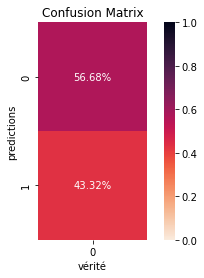

In [42]:
plot_confusion_matrix(test_df["activity"], test_df_eval['activity'])

Score f_beta : 31.030%
Score accuracy : 56.684%


(0.3103036011883197, 0.5668431502316347)

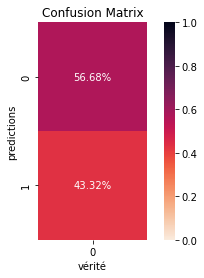

In [43]:
plot_confusion_matrix(test_df["activity"], test_df_eval['activity'])